In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/High.zip" "High.zip"
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/Low.zip" "Low.zip"
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/Normal.zip" "Normal.zip"

In [ ]:
!unzip -q High.zip
!unzip -q Low.zip
!unzip -q Normal.zip

In [ ]:
!mkdir CRC_data
%cp -av Normal1 CRC_data
%cp -av High1 CRC_data
%cp -av Low1 CRC_data

Streaming output truncated to the last 5000 lines.
'High1/Patient_035_09_High-Gradepatch_35.png' -> 'CRC_data/High1/Patient_035_09_High-Gradepatch_35.png'
'High1/Patient_035_09_High-Gradepatch_36.png' -> 'CRC_data/High1/Patient_035_09_High-Gradepatch_36.png'
'High1/Patient_035_09_High-Gradepatch_37.png' -> 'CRC_data/High1/Patient_035_09_High-Gradepatch_37.png'
'High1/Patient_035_09_High-Gradepatch_38.png' -> 'CRC_data/High1/Patient_035_09_High-Gradepatch_38.png'
'High1/Patient_035_09_High-Gradepatch_39.png' -> 'CRC_data/High1/Patient_035_09_High-Gradepatch_39.png'
'High1/Patient_035_09_High-Gradepatch_4.png' -> 'CRC_data/High1/Patient_035_09_High-Gradepatch_4.png'
'High1/Patient_035_09_High-Gradepatch_40.png' -> 'CRC_data/High1/Patient_035_09_High-Gradepatch_40.png'
'High1/Patient_035_09_High-Gradepatch_41.png' -> 'CRC_data/High1/Patient_035_09_High-Gradepatch_41.png'
'High1/Patient_035_09_High-Gradepatch_42.png' -> 'CRC_data/High1/Patient_035_09_High-Gradepatch_42.png'
'High1/Patient_

In [ ]:
!rm -rf Normal1
!rm -rf High1
!rm -rf Low1

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math



class SeparableConvolution(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.dwc = nn.Sequential(
            nn.Conv2d(input_channel, input_channel, kernel_size, stride, padding, dilation, groups=input_channel, bias=bias),
            nn.Conv2d(input_channel, output_channel, 1, 1, 0, 1, 1, bias=bias)
        )
    
    def forward(self, X):
        return self.dwc(X)

class Block(nn.Module):
    def __init__(self, input_channel, out_channel, reps, strides=1, relu=True, grow_first=True):
        super().__init__()
        if out_channel != input_channel or strides!=1:
            self.skipConnections = nn.Sequential(
                nn.Conv2d(input_channel, out_channel, 1, stride=strides, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        else:
            self.skipConnections = None
        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = input_channel
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConvolution(input_channel, out_channel, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_channel))
            filters = out_channel
        
        for _ in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConvolution(filters, filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConvolution(input_channel, out_channel, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_channel))

        if not relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3, strides, 1))

        self.rep = nn.Sequential(*rep)

    def forward(self, input):
        X = self.rep(input)

        if self.skipConnections:
            skip = self.skipConnections(input)
        else:
            skip = input
        
        X += skip
        return X

class Xception(nn.Module):
    def __init__(self, input_channel, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.relu = nn.ReLU(inplace=True)

        self.initBlock = nn.Sequential(
            nn.Conv2d(input_channel, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size = 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.block1=Block(64,128,2,2,relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,relu=True,grow_first=False)

        self.convolution3 = SeparableConvolution(1024,1536,3,1,1)
        self.batchnorm3 = nn.BatchNorm2d(1536)

        #do relu here
        self.convolution4 = SeparableConvolution(1536,2048,3,1,1)
        self.batchnorm4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, self.n_classes)

        #weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.initBlock(x)
        x = self.block1(x)
        
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.convolution3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        
        x = self.convolution4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        
        data, target = data.to(device), target.to(device)  
        
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    


def validate(model, device, val_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in val_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(val_loader.dataset), acc.avg))
    return loss.avg,acc.avg
##define test function



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('CRC_data/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, val_files, train_classes, val_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['High' 'Low' 'Normal']


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 10 # We use a small batch size here for training

batch_size_val = 10

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('CRC_data/', train_files, train_classes, 
                         transforms=image_transform)
val_dataset = Hist('CRC_data/', val_files, val_classes, 
                         transforms=image_transform)


#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=batch_size_val, 
                                           shuffle=True, num_workers=2)



Label: High


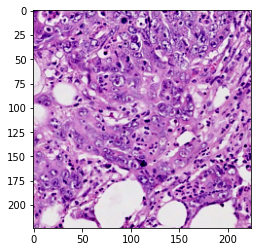

In [ ]:
# import library
import matplotlib.pyplot as plt
# Checking the data loader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# showing random image from dataloader
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
drive.flush_and_unmount()
!rm -rf /content/drive

In [ ]:
import os.path
from os import path
import torch.nn.functional as F
import torch.optim as optim

num_epoch = 50


for i in range(1):
  print('Experiment: ', i+1)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Xception(input_channel=3, n_classes=3).to(device)
  learning_rate = 0.0005
  weight_decay = 0.001
  for param in model.parameters():
    param.requires_grad = True
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)

  acc=0
  for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=validate(model, device, val_loader)
    if acc<acct:
      if path.exists("Xception9SGD.pth"):
        os.remove("Xception9SGD.pth")
      torch.save(model.state_dict(), 'Xception9SGD.pth')
      acc=acct

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Xception(input_channel=3, n_classes=3).to(device)
  model.load_state_dict(torch.load('Xception9SGD.pth', map_location=device))
  model=model.to(device)
  
 
print(acc)

Experiment:  1
1


<ipython-input-15-a57d00c2443e>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.7249

Test: Average loss: 0.9277, Accuracy: 2804/4656 (60.22%)

2


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.5840

Test: Average loss: 1.0147, Accuracy: 2621/4656 (56.29%)

3


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.5362

Test: Average loss: 0.5361, Accuracy: 3734/4656 (80.20%)

4


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.4815

Test: Average loss: 0.9492, Accuracy: 2693/4656 (57.84%)

5


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.4524

Test: Average loss: 0.4155, Accuracy: 3938/4656 (84.58%)

6


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.4144

Test: Average loss: 0.5431, Accuracy: 3687/4656 (79.19%)

7


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.3812

Test: Average loss: 0.2980, Accuracy: 4126/4656 (88.62%)

8


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.3625

Test: Average loss: 0.3925, Accuracy: 4054/4656 (87.07%)

9


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.3545

Test: Average loss: 0.4073, Accuracy: 3862/4656 (82.95%)

10


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.3346

Test: Average loss: 0.3199, Accuracy: 4105/4656 (88.17%)

11


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.3080

Test: Average loss: 0.3315, Accuracy: 4073/4656 (87.48%)

12


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.3003

Test: Average loss: 0.3098, Accuracy: 4081/4656 (87.65%)

13


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2722

Test: Average loss: 0.2391, Accuracy: 4269/4656 (91.69%)

14


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2741

Test: Average loss: 0.3840, Accuracy: 4108/4656 (88.23%)

15


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2495

Test: Average loss: 0.2603, Accuracy: 4216/4656 (90.55%)

16


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2456

Test: Average loss: 0.6031, Accuracy: 3621/4656 (77.77%)

17


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2312

Test: Average loss: 0.5382, Accuracy: 3778/4656 (81.14%)

18


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2244

Test: Average loss: 0.4232, Accuracy: 3982/4656 (85.52%)

19


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2181

Test: Average loss: 0.4342, Accuracy: 3903/4656 (83.83%)

20


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.2157

Test: Average loss: 0.3482, Accuracy: 4150/4656 (89.13%)

21


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1864

Test: Average loss: 0.2780, Accuracy: 4192/4656 (90.03%)

22


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1742

Test: Average loss: 0.2354, Accuracy: 4289/4656 (92.12%)

23


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1819

Test: Average loss: 0.4781, Accuracy: 3870/4656 (83.12%)

24


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1781

Test: Average loss: 0.2355, Accuracy: 4272/4656 (91.75%)

25


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1675

Test: Average loss: 0.2279, Accuracy: 4264/4656 (91.58%)

26


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1506

Test: Average loss: 0.2740, Accuracy: 4242/4656 (91.11%)

27


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1518

Test: Average loss: 0.3273, Accuracy: 4120/4656 (88.49%)

28


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1489

Test: Average loss: 0.2518, Accuracy: 4255/4656 (91.39%)

29


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1432

Test: Average loss: 0.3016, Accuracy: 4169/4656 (89.54%)

30


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1408

Test: Average loss: 0.3536, Accuracy: 4121/4656 (88.51%)

31


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1315

Test: Average loss: 0.2381, Accuracy: 4267/4656 (91.65%)

32


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1312

Test: Average loss: 0.2830, Accuracy: 4239/4656 (91.04%)

33


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1235

Test: Average loss: 0.3046, Accuracy: 4203/4656 (90.27%)

34


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1037

Test: Average loss: 0.3510, Accuracy: 4169/4656 (89.54%)

35


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1035

Test: Average loss: 0.2469, Accuracy: 4289/4656 (92.12%)

36


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1059

Test: Average loss: 0.2867, Accuracy: 4214/4656 (90.51%)

37


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0923

Test: Average loss: 0.2855, Accuracy: 4259/4656 (91.47%)

38


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1240

Test: Average loss: 0.3382, Accuracy: 4191/4656 (90.01%)

39


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1033

Test: Average loss: 0.2801, Accuracy: 4244/4656 (91.15%)

40


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1175

Test: Average loss: 0.3546, Accuracy: 4212/4656 (90.46%)

41


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0930

Test: Average loss: 0.2634, Accuracy: 4291/4656 (92.16%)

42


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0999

Test: Average loss: 0.2684, Accuracy: 4313/4656 (92.63%)

43


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0775

Test: Average loss: 0.3401, Accuracy: 4209/4656 (90.40%)

44


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.1034

Test: Average loss: 0.3940, Accuracy: 4121/4656 (88.51%)

45


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0709

Test: Average loss: 0.2782, Accuracy: 4269/4656 (91.69%)

46


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0743

Test: Average loss: 0.2875, Accuracy: 4276/4656 (91.84%)

47


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0804

Test: Average loss: 0.2776, Accuracy: 4274/4656 (91.80%)

48


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0612

Test: Average loss: 0.5193, Accuracy: 4100/4656 (88.06%)

49


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0885

Test: Average loss: 0.3364, Accuracy: 4187/4656 (89.93%)

50


  0%|          | 0/1087 [00:00<?, ?it/s]

Train: Average loss: 0.0666

Test: Average loss: 0.3167, Accuracy: 4226/4656 (90.76%)

92.63316151202748
